## IMPORTANT: THis jupyter notebook is not maintained and should not be used at the moment.
## For an example of how to use the library please refer to all the main files (main-MLP, main-CNN, etc.)

# Installation
The purpose of this notebook is to give a working example of the library and how to use it. First, we begin by installing the library. Note that it takes some time to install the library because of the dependencies, be patient!

In [1]:
%pip install git+https://github.com/JadM133/RRAEs.git

  Cloning https://github.com/JadM133/RRAEs.git to c:\users\jadmo\appdata\local\temp\pip-req-build-do75ru3_
  Resolved https://github.com/JadM133/RRAEs.git to commit 15ead3bd722a53bce6d609938362fc74844eaae9
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/JadM133/RRAEs.git 'C:\Users\jadmo\AppData\Local\Temp\pip-req-build-do75ru3_'


Now that the library is installed, you can acces the library with the name ``RRAEs``. We begin by creating a simple training data, the library presents a function within ``utilities`` named ``get_data`` that generates the data used in the paper and many more. In this case, we will use the shifted sine functions as a simple example.

Train shape: (200, 17), or (200, 17)
Test shape: (200, 80), or (200, 80)
Train parameters shape: (17, 1)
Test parameters shape: (80, 1)


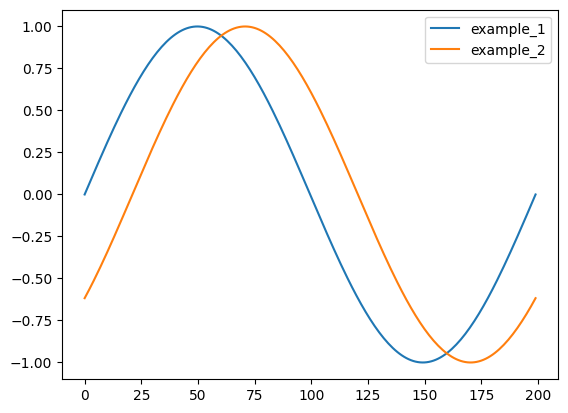

In [3]:
from RRAEs.utilities import get_data
import matplotlib.pyplot as plt
import jax.numpy as jnp
x_train, x_test, p_train, p_test, y_train, y_test, _, _, _ = get_data("shift")
# In general, you won't use get_data, you will have your own data with the same shapes.
print(f"Train shape: {x_train.shape}, or {y_train.shape}")
print(f"Test shape: {x_test.shape}, or {y_test.shape}")
print(f"Train parameters shape: {p_train.shape}")
print(f"Test parameters shape: {p_test.shape}")
plt.plot(x_train[:, 0], label="example_1")
plt.plot(x_train[:, 2], label="example_2")
plt.legend()

In this case, ``x_train`` and ``y_train`` are the same matrices, since we want the autoencoder to have as an output the same thing as the input. Similarly, ``x_test`` and ``y_test`` are the same. We can also see that we only have one parameter (the last dimension of ``p_train`` and ``p_test``), which is expected for the problem of the shifted sines (shifted by one parameter). In general, when generating your own data, x and y should have the shape (T x N) and the parameters should have a shape of (N x P), N being the number of samples (wether for train or test), T being the time discretisation dimension, and P being the dimension of the parametric space.

Next, we creat the model,

In [4]:
from RRAEs import Strong_RRAE_MLP
import jax.random as jrandom
latent_size = 520 # The dimension L of the latent space
k_max = 1 # The number of features in the latent space
kwargs_enc={"width_size":64, "depth":1}
kwargs_dec={"width_size":64, "depth":5}
model_key = jrandom.PRNGKey(0) # JAX needs key for generating random values, this is a necessary keword argument in the classes.

model_Strong = Strong_RRAE_MLP(x_train.shape[0], latent_size, k_max, key=model_key, kwargs_enc=kwargs_enc, kwargs_dec=kwargs_dec)

# You can give any kwargs needed for the encoder in kwargs_enc, and for the decoder in kwargs_dec. If nothing is given,
# the encoder will have a depth of 1 and a width of 64, and the decoder will have a depth of 6 and a width of 64.

Let's try the model now by aplying it to our training data.

In [5]:
print(f"x_train shape before: {x_train.shape}")
print(f" Shape after Strong: {model_Strong(x_train).shape}")

x_train shape before: (200, 17)
 Shape after Strong: (200, 17)


We expect all shapes to be the same since we want to predict the original values as output, great!

Now, let's train the model on our data. The library provides a trainor class that can help with training.

The training class provides simple functions for fitting and evaluating Networks. It is also an easy
way of applying normalization, and mapping the models over the data.

In this case, we will use a subclass, ``RRAE_Trainor_class``, specifically designed for Rank Reduction Autoencoders.

We define the trainor class as follows, 

In [6]:
from RRAEs import RRAE_Trainor_class 
# You can use Trainor_class instead for any other equinox model, 
# RRAE_trainor_class is specifically fine-tuned for RRAEs.

model_cls = Strong_RRAE_MLP # Without parenthesis! Only the class

trainor = RRAE_Trainor_class(
            x_train,
            model_cls,
            in_size=x_train.shape[0],
            latent_size=latent_size,
            k_max=k_max,
            norm_in="minmax", # could choose "meanstd", or "None"
            norm_out="minmax", # could choose "meanstd", or "None"
            out_train=x_train,
            folder=f"test/", # folder to save later
            file=f"testing_strong.pkl", # file in folder to save later
            key=jrandom.PRNGKey(0),
        )

Now, we can use the ``fit`` method of the trainor class, and give it any training arguments you want.

Note that as discussed in the paper, RRAEs might benefit of some fine tuning of the final basis found.
Accordingly, the AE trainor class used performs two types of training. First, RRAEs are trained with
an SVD in the latent space. Then, the fine tuning is done with a fixed basis and a projection in the
latent space.

In [7]:
# Here define training arguments for the RRAEs with an SVD.
training_kwargs = {
            "step_st": [1500], # number of batches strategy
            "batch_size_st": [20, 20, 20], # batch size strategy
            "lr_st": [1e-3, 1e-4], # learning rate strategy
            "print_every": 100,
        }

# Here define the parameters of fine-tuning. Set step_st to [0] if you don't want to fine-tune.
ft_kwargs = {
            "step_st": [200], # number of batches strategy
            "batch_size_st": [20, 20, 20], # batch size strategy
            "lr_st": [1e-4], # learning rate strategy
            "print_every": 100,
        }

_ = trainor.fit(
    x_train,
    y_train,
    training_key=jrandom.PRNGKey(50),
    training_kwargs=training_kwargs,
    ft_kwargs=ft_kwargs,
)

Training RRAEs...
Step: 0, Loss: 99.69287872314453, Computation time: 0.4798640999943018
Step: 100, Loss: 57.13981246948242, Computation time: 0.4930902011692524
Step: 200, Loss: 41.788246154785156, Computation time: 0.5544761992059648
Step: 300, Loss: 28.572261810302734, Computation time: 0.5965746999718249
Step: 400, Loss: 12.33699893951416, Computation time: 0.6374554024077952
Step: 500, Loss: 5.341980457305908, Computation time: 0.6249467968009412
Step: 600, Loss: 4.298551082611084, Computation time: 0.6619425984099507
Step: 700, Loss: 5.103562831878662, Computation time: 0.5766922989860177
Step: 800, Loss: 5.20054817199707, Computation time: 0.5802274974994361
Step: 900, Loss: 2.717602252960205, Computation time: 0.639633399900049
Step: 1000, Loss: 2.6641998291015625, Computation time: 0.5847030002623796
Step: 1100, Loss: 2.445437431335449, Computation time: 0.6536898026242852
Step: 1200, Loss: 2.023834466934204, Computation time: 0.5509652998298407
Step: 1300, Loss: 2.08139991760

1it [00:00, 25.93it/s]

Fine tuning the basis found ...


Step: 0, Loss: 1.6275497674942017, Computation time: 0.25699480017647147
Step: 100, Loss: 0.8273159265518188, Computation time: 0.311546697281301
Step: 199, Loss: 0.7411112189292908, Computation time: 0.31829110300168395


Next, we show how to evaluate the network on train/test. Again, this can be simply done using the trainor class.

In [8]:
preds = trainor.evaluate(x_train, y_train, x_test, y_test, p_train, p_test)

Finding train predictions...


100%|██████████| 1/1 [00:00<00:00, 15.06it/s]

Train error on original output: 

 1.279285
Train error on normalized output:  0.73879516
Test error on original output:  6.088067
Test error on normalized output:  3.51509
Total training time:  0.8868326004594564
Finding train latent space used for interpolation...


100%|██████████| 1/1 [00:00<00:00, 99.63it/s]


Decoding interpolated latent space ...


5it [00:00, 46.08it/s]               


Test (interpolation) error over original output:  2.2664022
Finding Normalized pred of interpolated latent space ...


5it [00:00, 152.10it/s]              


Finding Normalized output of interpolated latent space ...


5it [00:00, 152.38it/s]              

Test (interpolation) error over normalized output:  1.3085613


Note that since ``p_train`` and ``p_test`` are given, a few things happen.

1. The model is evaluate over the training set, while projecting on the basis in the latent space (no more SVD).
2. The same is done for the test set.
3. The latent space for all training data is found.
4. The latent space of the test set is foun by interpolating the training latent spaces (using linear interpolation between p_train values and p_test).
5. The interpolated latent spaces are decoded to find the interpolation error.

So basically, the Neural Network is evaluated over the test using interpolation and simply passing through the Autoencoder with a projection onto the basis.

The predictions given by the ``evaluate`` method is a dictionary with the errors and predictions (over train, test and interpolation test).

In [9]:
# _o stands for original (no normalization) and its absence stands for normalized.
preds.keys()

dict_keys(['error_train', 'error_test', 'error_train_o', 'error_test_o', 'y_pred_train_o', 'y_pred_test_o', 'y_pred_train', 'y_pred_test', 'error_interp_test', 'error_interp_test_o', 'y_pred_interp_test_o', 'y_pred_interp_test'])

Let's plot one our predictions on one of the test curves.

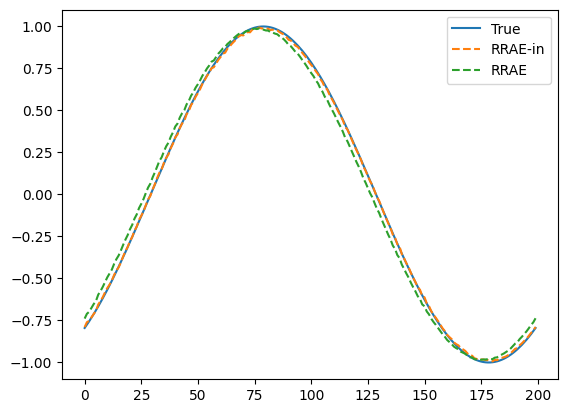

In [10]:
idx = 15
plt.plot(y_test[:, idx], label="True")
plt.plot(preds["y_pred_interp_test_o"][:, idx], label="RRAE-in", linestyle="--")
plt.plot(preds["y_pred_test_o"][:, idx], label="RRAE", linestyle="--")
plt.legend()

The autoencoder model also allows you to perform seperate operations (e.g. encoe and decode), normalization is done automatically.

In [ ]:
encoded = trainor.model.encode(x_train) # data is normalized before encode

# We con both encode, and project on the basis as follows (do not forget the apply_basis argument).
# Note that when using trainor.evaluate, this is done automatically.
latent = trainor.model.latent(x_train, apply_basis=trainor.basis) # data is normalized before latent

# Then we can decode the results to find the prediction
decoded = trainor.model.decode(latent) # data is inv normalized after decode
print(jnp.linalg.norm(x_train - decoded)/jnp.linalg.norm(x_train)*100) #Finding the error in percentage

1.2792777


Note that the function "latent", has some useful arguments as well:

In [12]:
# get_svd=True returns the basis, and corresponding coefficients of the
# truncated SVD in the latent space (Note: if the svd is USV^T, then
# the basis is U, the coefficients are SV^T).
# The coeffs are the reduced representation of the data (shape k_max x D).
basis, coeffs = trainor.model.latent(x_train, get_svd=True)
print(coeffs.shape)

# By default, the latent space performs the truncated SVD by the value of
# k_max specified above. This is needed when performing training. But to
# evaluate an RRAE, remember that we should project on the basis already found
# (without the SVD). This can be done by setting apply_basis=basis wether in the
# latent, or in the __call__ function of the model.
latent_space = trainor.model.latent(x_train, basis=basis)

(1, 17)


Some of the trainor attributes and methods that could be useful:

In [13]:
print(trainor.__dict__.keys()) #  a list of all the attributes of the trainor, you can find the errors, the model, the basis, etc.

# NOTE: In case your data is big and you want to perform any function using
# mapped batches, the trainor class provides eval_with_batches, used as follows.

# Step 1: Specify the function you want to apply
call_func = lambda x: trainor.model.latent(x, get_svd=True)[0]

latent_space_mean = trainor.model.eval_with_batches(x_train, batch_size=32, call_func=call_func, end_type="mean", key=jrandom.key(0))

print(f"Mean shape: {latent_space_mean.shape}")

latent_space_all = trainor.model.eval_with_batches(x_train, batch_size=32, call_func=call_func, key=jrandom.key(0))

print(f"All shape: {latent_space_all.shape}")

# NOTE: By default, the function assumes only ONE ARRAY as an output, so the results of each batch
# are appended in a list, and the concatenated along the last dimension. You could chose end_type
# to be "mean" where the function would return the mean of the list, "first" if you only want the result
# over the first batch, and None if you want the list of results. 

dict_keys(['pre_func_inp', 'pre_func_out', 'model', 'all_kwargs', 'folder', 'ts', 'file', 'fitted', 'batch_size', 't_all', 'basis', 'error_train_o', 'error_train', 'error_test_o', 'error_test', 'error_interp_test_o', 'error_interp_test'])
Mean shape: (520, 1)
All shape: (520, 17)


Finally, you can save the model by using the built-in ``save`` function of the trainor class, it will save the model in the foler and file that you specified previously when defining the trainor class as follows.

In [14]:
trainor.save(coeffs=coeffs, basis=basis) # you could save any other parameter by passing it as a keyword argument

Model saved in test/testing_strong.pkl


Later on, if you want to load the trainor again, you define a trainor class instance with no attributes and load the class as follows

In [15]:
import os
folder = f"test/"
file = f"testing_strong.pkl"
new_trainor = RRAE_Trainor_class()
new_trainor.load(os.path.join(folder, file), erase=True) # erase=True to delete the saved file, only to use in this tutorial.

new_trainor.model # Access the model, and all the other attributes of the trainor.

Norm(
  model=BaseClass(
    map_axis=None,
    model=Strong_RRAE_MLP(
      encode=BaseClass(
        map_axis=-1,
        model=MLP_with_linear(
          layers=(
            Linear(
              weight=f32[64,200],
              bias=f32[64],
              in_features=200,
              out_features=64,
              use_bias=True
            ),
            Linear(
              weight=f32[520,64],
              bias=f32[520],
              in_features=64,
              out_features=520,
              use_bias=True
            )
          ),
          layers_l=(),
          activation=[<wrapped function relu>],
          activation_l=[],
          use_bias=True,
          use_final_bias=True,
          in_size=200,
          out_size=520,
          width_size=[64],
          depth=1,
          final_activation=<function <lambda>>,
          final_activation_l=<function <lambda>>
        )
      ),
      decode=BaseClass(
        map_axis=-1,
        model=MLP_with_linear(
        